# Super-Resolution 2D ResNet Model Architecture MRI

## 1. Libraries

In [ ]:
!nvidia-smi

Thu May 22 14:25:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
from keras import layers
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.keras.backend.clear_session()

## 2. Managing Data

Carga los datos de las imágenes preprocesadas desde archivos NPY

In [ ]:
path = '/content/drive/My Drive/Tesis/Data/'

In [ ]:
validation_high_mri = np.load(f'{path}validation_high_mri.npy')
validation_low_mri = np.load(f'{path}validation_low_mri.npy')
train_high_mri = np.load(f'{path}train_high_mri.npy')
train_low_mri = np.load(f'{path}train_low_mri.npy')
test_high_mri = np.load(f'{path}test_high_mri.npy')
test_low_mri = np.load(f'{path}test_low_mri.npy')

In [ ]:
print("Shape of validation high mri:", validation_high_mri.shape)
print("Shape of validation low mri:", validation_low_mri.shape)
print("Shape of training high mri:", train_high_mri.shape)
print("Shape of training low mri:", train_low_mri.shape)
print("Shape of test high mri:", test_high_mri.shape)
print("Shape of test low mri:", test_low_mri.shape)

Shape of validation high mri: (3147, 256, 256, 1)
Shape of validation low mri: (3147, 256, 256, 1)
Shape of training high mri: (25179, 256, 256, 1)
Shape of training low mri: (25179, 256, 256, 1)
Shape of test high mri: (3148, 256, 256, 1)
Shape of test low mri: (3148, 256, 256, 1)


## 3. Visualizing the Data

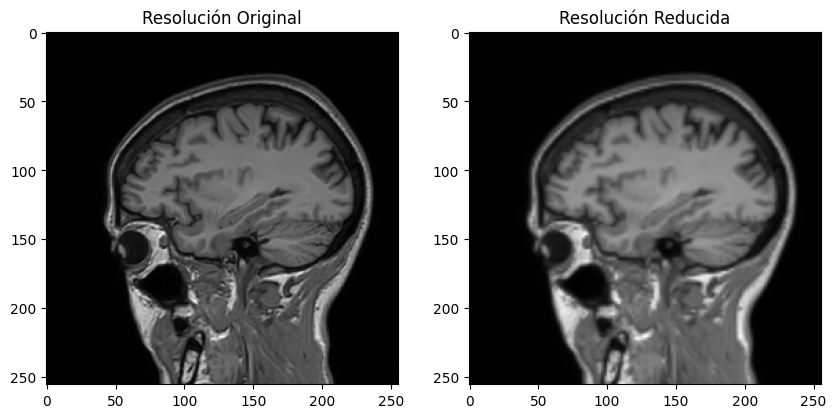

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_high_mri[1000], cmap='gray')
plt.title('Resolución Original')
plt.subplot(1, 2, 2)
plt.imshow(train_low_mri[1000], cmap='gray')
plt.title('Resolución Reducida')
plt.show()

## 4. Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, low_res_images, high_res_images, batch_size):
        self.low_res_images = low_res_images
        self.high_res_images = high_res_images
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(len(self.low_res_images) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size
        low_res_batch = self.low_res_images[start_index:end_index]
        high_res_batch = self.high_res_images[start_index:end_index]
        return low_res_batch, high_res_batch

In [ ]:
train_generator = DataGenerator(train_low_mri, train_high_mri, batch_size=32)
validation_generator = DataGenerator(validation_low_mri, validation_high_mri, batch_size=32)

## 5. Defining the Model

In [ ]:
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding='same', activation='relu', strides=2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
        downsample.add(keras.layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding='same', activation='relu', strides=2))
    if dropout:
        upsample.add(keras.layers.Dropout(0.2))
        #upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape=[256,256,1])
    # Capas convolucionales
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),False)(d2)
    d4 = down(512,(3,3),False)(d3)
    d5 = down(512,(3,3),False)(d4)
    # Upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),True)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),True)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),True)(u4)
    u5 = layers.concatenate([u5, inputs])
    output = layers.Conv2D(1, (2,2), strides=1, padding='same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = model()
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      1,280 │ input_layer[0][0] │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    147,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    295,168 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  1,180,160 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  2,359,808 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16,    │  2,359,808 │ sequential_4[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 32, 32,    │  2,359,552 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64,    │    589,952 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 128, 128,  │    295,040 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 256)              │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 256, 256,  │      6,915 │ concatenate_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256, 256,  │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 4)                │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │         17 │ concatenate_4[0]

 Total params: 9,595,284 (36.60 MB)

 Trainable params: 9,595,284 (36.60 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Compiling the Model

In [ ]:
# Definir la métrica SSIM
def ssim_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    #ssim_value = tf.map_fn(lambda x: tf.image.ssim(x[0], x[1], max_val=1.0), (y_true, y_pred), dtype=tf.float32)
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(ssim_value)

# Definir la métrica PSNR
def psnr_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_value)

# SSIM como función de pérdida
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5), loss='mean_absolute_error', metrics=[psnr_metric, ssim_metric])

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/Tesis/SRResNet/model_checkpoints/sr_resnet_trained.keras",
    save_freq="epoch",  # Guarda en cada época
    verbose=1
)

## 7. Fitting the Model

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[checkpoint_callback])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0043 - psnr_metric: 49.2627 - ssim_metric: 0.9559
Epoch 1: saving model to /content/drive/My Drive/Tesis/SRResNet/model_checkpoints/sr_resnet_trained.keras
786/786 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - loss: 0.0043 - psnr_metric: 49.2671 - ssim_metric: 0.9559 - val_loss: 0.0015 - val_psnr_metric: 58.3342 - val_ssim_metric: 0.9905
Epoch 2/50
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0025 - psnr_metric: 52.5123 - ssim_metric: 0.9787
Epoch 2: saving model to /content/drive/My Drive/Tesis/SRResNet/model_checkpoints/sr_resnet_trained.keras
786/786 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - loss: 0.0025 - psnr_metric: 52.5152 - ssim_metric: 0.9787 - val_loss: 0.0013 - val_psnr_metric: 59.3478 - val_ssim_metric: 0.9926
Epoch 3/50
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0020 - psnr_metric: 54.5217 - ssim_metric: 0.9866
Epoch 3: saving model to /content/drive/My Drive/Tesis/SRResNet/model_checkpoints/sr_resnet_trained.keras
786/

In [ ]:
model.save("/content/drive/My Drive/Tesis/SRResNet/sr_2d_resnet_mri_trained.keras")

## 8. Evaluating the Model

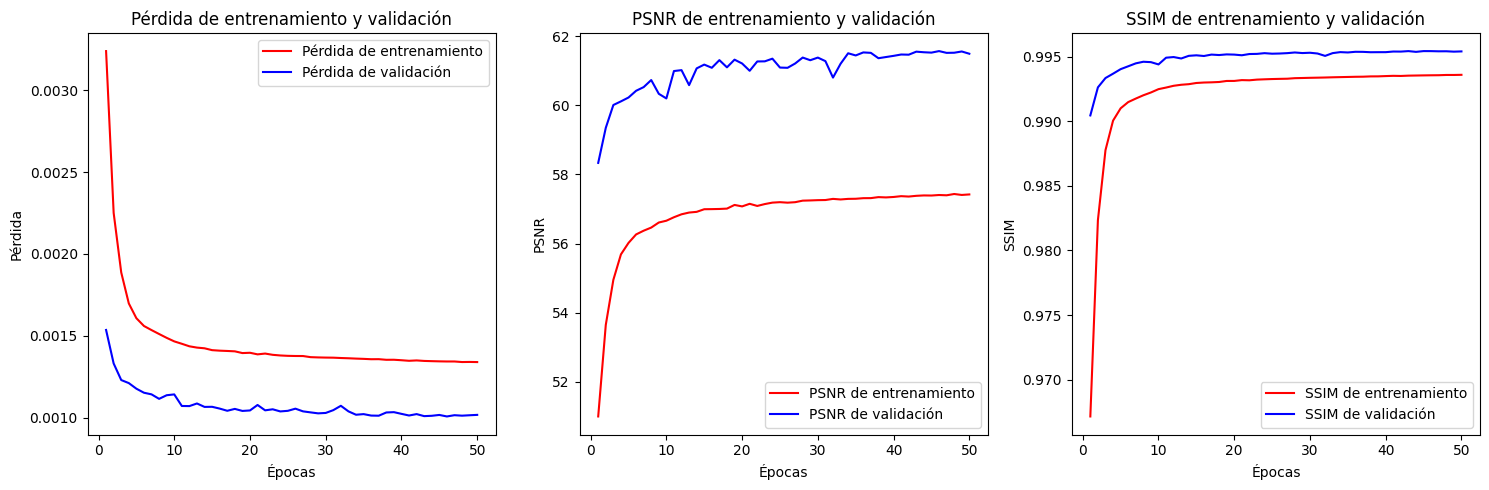

In [ ]:
# Obtener las métricas del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
psnr = history.history['psnr_metric']
val_psnr = history.history['val_psnr_metric']
ssim = history.history['ssim_metric']
val_ssim = history.history['val_ssim_metric']

np.save('/content/drive/My Drive/Tesis/SRResNet/loss.npy', loss)
np.save('/content/drive/My Drive/Tesis/SRResNet/val_loss.npy', val_loss)
np.save('/content/drive/My Drive/Tesis/SRResNet/psnr.npy', psnr)
np.save('/content/drive/My Drive/Tesis/SRResNet/val_psnr.npy', val_psnr)
np.save('/content/drive/My Drive/Tesis/SRResNet/ssim.npy', ssim)
np.save('/content/drive/My Drive/Tesis/SRResNet/val_ssim.npy', val_ssim)

epochs = range(1, len(loss) + 1)

# Crear una figura con 3 subgráficas en una fila
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Graficar la pérdida
axs[0].plot(epochs, loss, 'r', label='Pérdida de entrenamiento')
axs[0].plot(epochs, val_loss, 'b', label='Pérdida de validación')
axs[0].set_title('Pérdida de entrenamiento y validación')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

# Graficar el PSNR
axs[1].plot(epochs, psnr, 'r', label='PSNR de entrenamiento')
axs[1].plot(epochs, val_psnr, 'b', label='PSNR de validación')
axs[1].set_title('PSNR de entrenamiento y validación')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('PSNR')
axs[1].legend()

# Graficar el SSIM
axs[2].plot(epochs, ssim, 'r', label='SSIM de entrenamiento')
axs[2].plot(epochs, val_ssim, 'b', label='SSIM de validación')
axs[2].set_title('SSIM de entrenamiento y validación')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('SSIM')
axs[2].legend()

# Ajustar el layout
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Tesis/SRResNet/train_resnet.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluación en el conjunto de validación
loss, psnr_value, ssim_value = model.evaluate(validation_low_mri, validation_high_mri)
print(f"Loss: {loss}")
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 9.3016e-04 - psnr_metric: 62.9315 - ssim_metric: 0.9959
Loss: 0.001014301902614534
PSNR: 61.58717727661133
SSIM: 0.9954665303230286


## 9. Making Predictions

In [ ]:
def mse_metric(target, ref):
    mse_value = tf.square(target - ref)
    return tf.reduce_mean(mse_value)

def compare_images(real, pred,i):
    scores = []
    scores.append(i)
    scores.append(psnr_metric(real, pred).numpy())
    scores.append(ssim_metric(real, pred).numpy())
    scores.append(mse_metric(real, pred).numpy())
    print(scores)
    return scores

In [ ]:
def plot_images(high,low,predicted,i):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High MRI', color='black', fontsize=20)
    plt.imshow(high, cmap='gray')
    plt.subplot(1,3,2)
    plt.title('Low MRI', color='black', fontsize=20)
    plt.imshow(low, cmap='gray')
    plt.subplot(1,3,3)
    plt.title('Predicted MRI', color='black', fontsize=20)
    plt.imshow(predicted, cmap='gray')
    plt.savefig(f'/content/drive/My Drive/Tesis/SRResNet/result_resnet_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
[50, np.float32(64.55181), np.float32(0.9995757), np.float32(3.5135486e-07)]


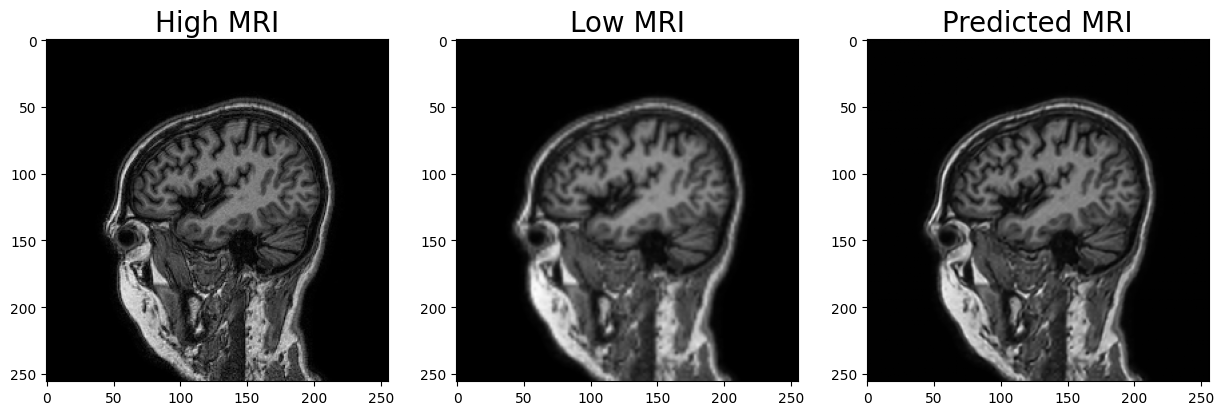

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[60, np.float32(64.230835), np.float32(0.9995396), np.float32(3.7817372e-07)]


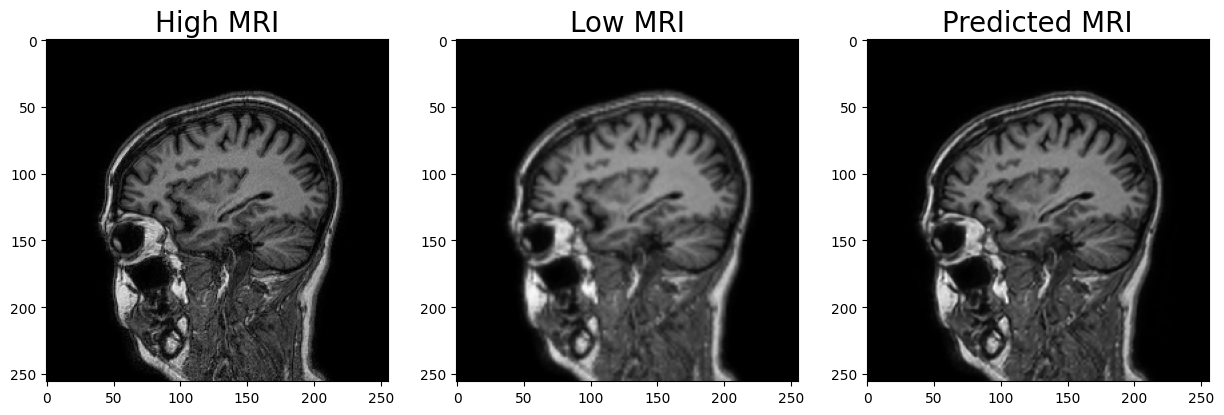

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[70, np.float32(63.677803), np.float32(0.9994822), np.float32(4.293915e-07)]


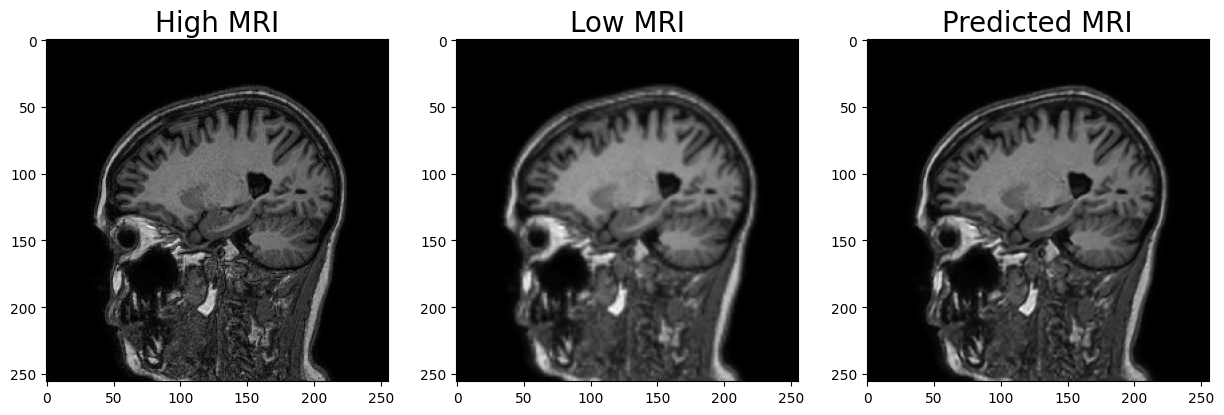

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[80, np.float32(63.771584), np.float32(0.9994911), np.float32(4.2018627e-07)]


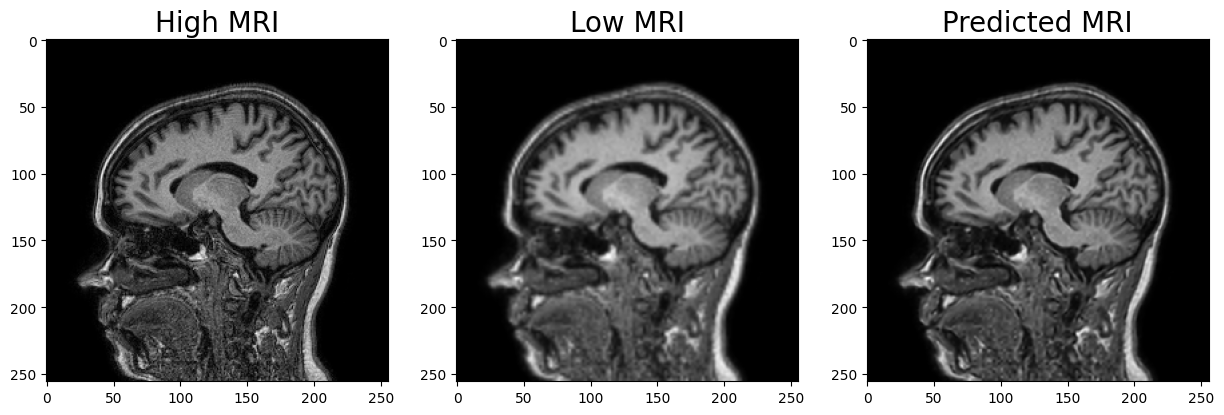

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[90, np.float32(63.82995), np.float32(0.9994986), np.float32(4.1457685e-07)]


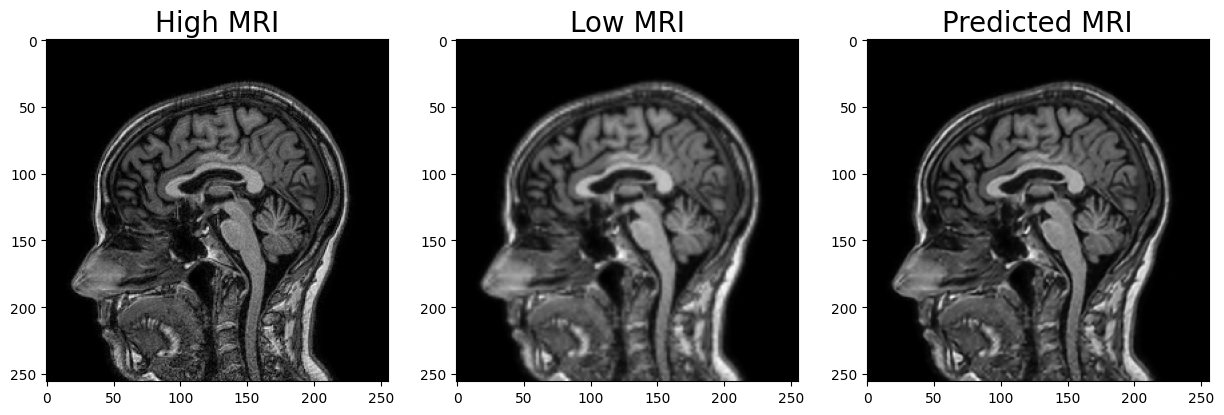

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[100, np.float32(63.768337), np.float32(0.9994925), np.float32(4.205071e-07)]


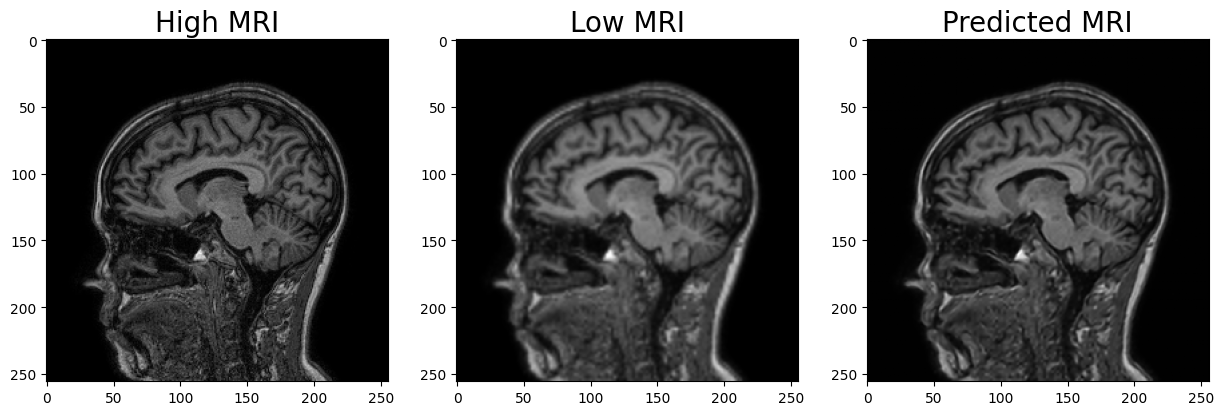

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[110, np.float32(63.32186), np.float32(0.99943775), np.float32(4.660064e-07)]


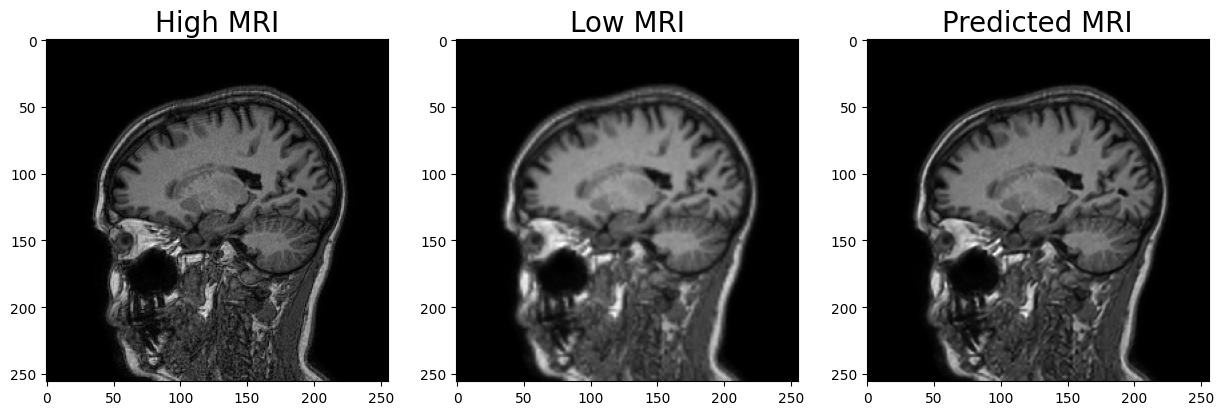

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[120, np.float32(64.15364), np.float32(0.9995333), np.float32(3.8493928e-07)]


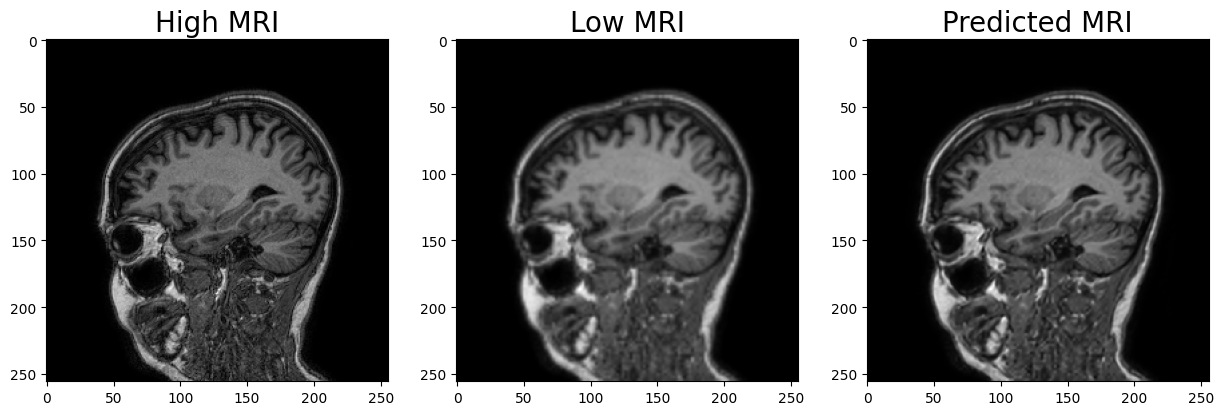

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[130, np.float32(64.051575), np.float32(0.99952364), np.float32(3.9414732e-07)]


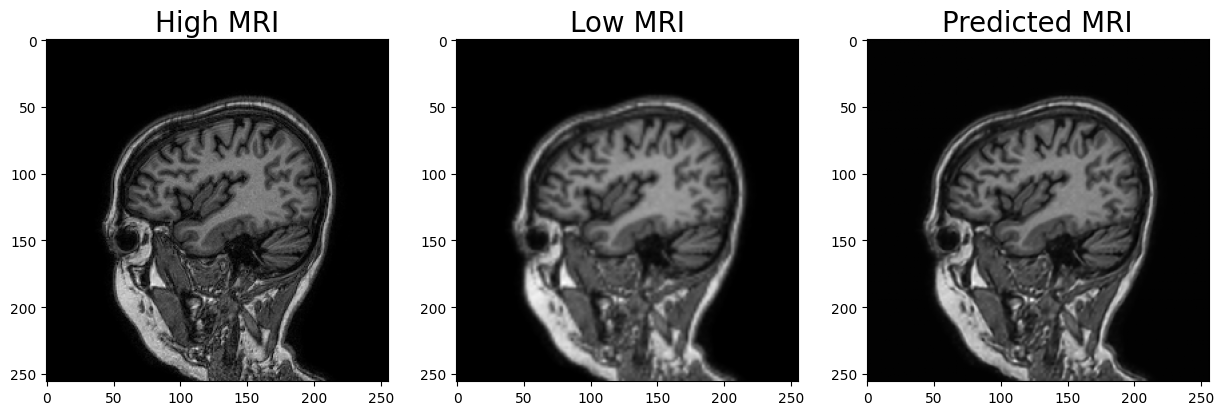

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[140, np.float32(65.90943), np.float32(0.9996932), np.float32(2.5730242e-07)]


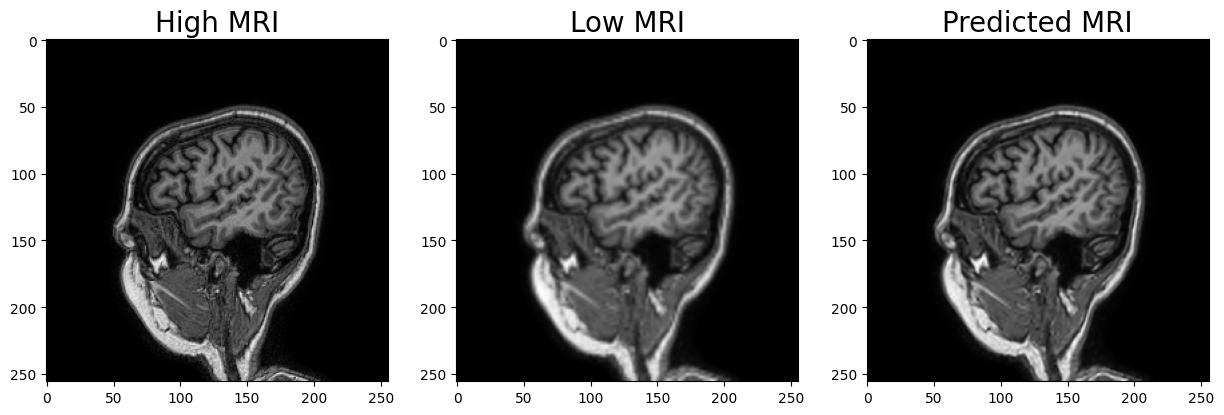

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[150, np.float32(67.76037), np.float32(0.99979126), np.float32(1.6843138e-07)]


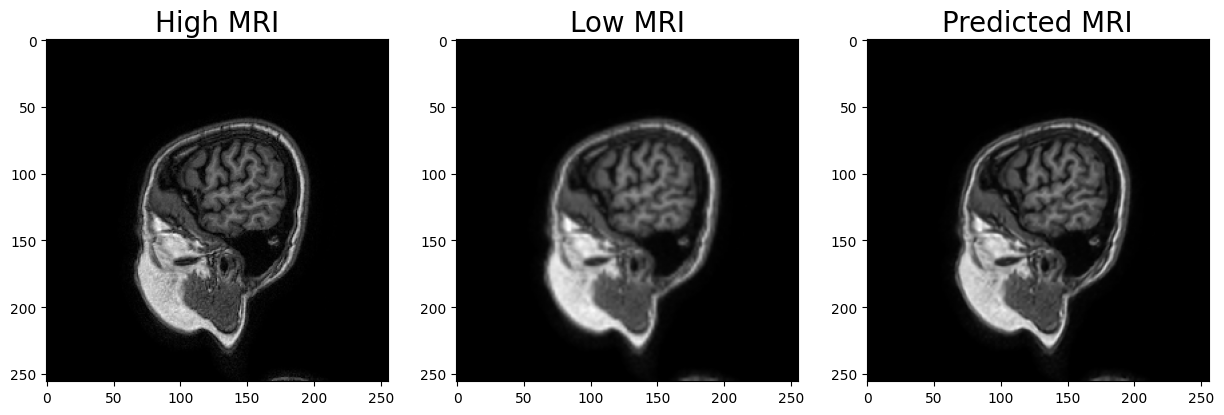

In [ ]:
scores = []
for i in [50,60,70,80,90,100,110,120,130,140,150]:
    predicted = model.predict(test_low_mri[i].reshape(1,256,256,1))
    scores.append(compare_images(test_high_mri[i], predicted,i))
    plot_images(test_high_mri[i],test_low_mri[i],predicted[0],i)

In [ ]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ['Item','PSNR','SSIM','MSE']
df_scores

,Item,PSNR,SSIM,MSE
0,50,64.551811,0.999576,3.513549e-07
1,60,64.230835,0.999540,3.781737e-07
2,70,63.677803,0.999482,4.293915e-07
3,80,63.771584,0.999491,4.201863e-07
4,90,63.829948,0.999499,4.145768e-07
5,100,63.768337,0.999493,4.205071e-07
6,110,63.321861,0.999438,4.660064e-07
7,120,64.153641,0.999533,3.849393e-07
8,130,64.051575,0.999524,3.941473e-07
9,140,65.909431,0.999693,2.573024e-07
